In [1]:
from copy import deepcopy
from itertools import combinations
import typing as tp

import numpy as np
import pandas as pd
from numpy.linalg import lstsq
from scipy.optimize import linprog

from matplotlib import pyplot as plt
from citk.layer import Dense, FuzzyGMDHLayer
from citk.model import FFN, GMDH
from citk.functions import ReLU, Linear, BellMembership, GaussianMembership, Poly
from citk.losses import MSE, FMSE
from citk.optimisers import SGDOptimizer

from utils import seed_everything, normalize_df, create_lags

%matplotlib inline

In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /

# Data

In [2]:
RANDOM_SEED = 42
N_LAGS = 2
INITIAL_TEST_LEN = 8

seed_everything(RANDOM_SEED)

data = pd.read_csv('../data/data.csv', encoding='cp1251', sep=';', decimal=',').dropna()

train_df, test_df = data.iloc[:-INITIAL_TEST_LEN], data.iloc[-INITIAL_TEST_LEN:]

train_df, test_df = create_lags(
    train_df, test_df, 
    train_df.columns.tolist(), 
    N_LAGS
)

y_col = 'ІСЦ (+1)'
X_col = train_df.columns.tolist()
X_col.remove(y_col)

train_df, test_df = normalize_df(train_df, test_df, X_col)

X_train = train_df[X_col].values
X_test = test_df[X_col].values
y_train = train_df[y_col].values[..., np.newaxis]
y_test = test_df[y_col].values[..., np.newaxis]

/home/vsydorskyi/src/Neural_Net_Genetic_Alg/examples/utils.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[f'{col}_{sh}'] = train_df.shift(sh)[col]
/home/vsydorskyi/src/Neural_Net_Genetic_Alg/examples/utils.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[f'{col}_{sh}'] = test_df.shift(sh)[col]


# GMDH 

In [3]:
model = GMDH(
            method_type='fuzzy', 
            poli_type='partial_quadratic',
            loss=MSE, 
            confidence=0.9,
        )

In [4]:
model, history  = model.fit(
    (X_train, y_train),
    (X_test, y_test),
    max_gmdh_layers=10,
    n_best_to_take=30
)

/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/scipy/optimize/_linprog.py:514: OptimizeWarning: x0 is used only when method is 'revised simplex'. 
  warn(warning_message, OptimizeWarning)


# Predict and Visualise losses

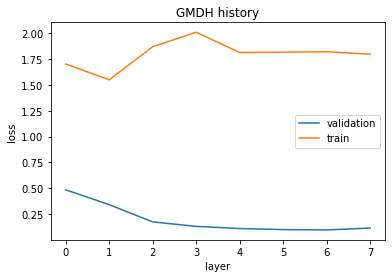

In [5]:
plt.title('GMDH history')
plt.plot(history['validation_loss'], label='validation')
plt.plot(history['train_loss'], label='train')
plt.xlabel('layer')
plt.ylabel('loss')
plt.legend()
plt.show()

In [6]:
prediction = model.predict(X_test)
prediction_train = model.predict(X_train)

In [7]:
print(f"Test MSE: {MSE(y_test, prediction)[0]}")
print(f"Train MSE: {MSE(y_train, prediction_train)[0]}")

Test MSE: 0.09840075234489337
Train MSE: 1.8199672379000729


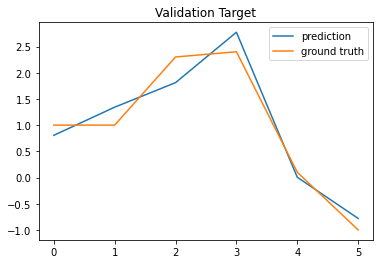

In [8]:
plt.title('Validation Target')
plt.plot(prediction, label='prediction')
plt.plot(y_test, label='ground truth')
plt.legend()
plt.show()

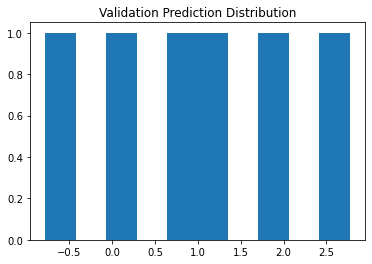

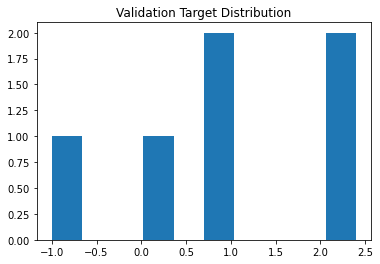

In [9]:
plt.title('Validation Prediction Distribution')
plt.hist(prediction)
plt.show()

plt.title('Validation Target Distribution')
plt.hist(y_test)
plt.show()